**Time Series in Pandas**
---

#### Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important piece of the Pandas time series tools. The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series-specific operations.

We will take a look at a few of those here, using some stock price data as an example. Because Pandas was developed largely in a finance context, it includes some very specific tools for financial data. For example, the accompanying `pandas-datareader` package (installable via `conda install pandas-datareader`), knows how to import financial data from a number of available sources, including Yahoo finance, Google Finance, and others. Here we will load Google's closing price history:

In [42]:
from pandas_datareader import data
import pandas as pd
import numpy as np

# yahoo finance using datareader
goog = data.DataReader('GOOG', start='2004', end='2016', data_source='stooq')

goog.reset_index(inplace=True)
goog.head()

,Date,Open,High,Low,Close,Volume
0,2015-12-31,38.4750,38.4750,37.9170,37.9440,21400960
1,2015-12-30,38.8300,38.8800,38.3450,38.5500,17363480
2,2015-12-29,38.3345,38.9990,38.3215,38.8300,35300240
3,2015-12-28,37.6460,38.1495,37.4760,38.1255,30314320
4,2015-12-24,37.4775,37.5675,37.3310,37.4200,10544460


In [44]:
goog['Date'] = pd.to_datetime(goog['Date'])

In [49]:
goog.set_index('Date', inplace=True)
goog.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-31,38.4750,38.4750,37.9170,37.9440,21400960
2015-12-30,38.8300,38.8800,38.3450,38.5500,17363480
2015-12-29,38.3345,38.9990,38.3215,38.8300,35300240
2015-12-28,37.6460,38.1495,37.4760,38.1255,30314320
2015-12-24,37.4775,37.5675,37.3310,37.4200,10544460


In [6]:
goog = goog['Close']

In [9]:
# import ggplot
from lets_plot import *
LetsPlot.setup_html()

In [47]:
# X = goog years
X = goog['Date'].tolist()
# get years from date

Y = goog['Close']

# create a plot
p = ggplot({'X': X, 'Y': Y}, aes('X', 'Y')) + geom_line(color = 'yellow') + ggsize(600, 250) + theme_classic()
p + flavor_high_contrast_dark()

#### Resampling and converting frequencies

One common need for time series data is resampling at a higher or lower frequency.\
This can be done using the `resample()` method, or the much simpler `asfreq()` method.\
The primary difference between the two is that ``resample() is fundamentally a data aggregation, while `asfreq()` is fundamentally a data selection.

Taking a look at the Google closing price, let's compare what the two return when we down-sample the data. Here we will resample the data at the end of business year:

<Axes: xlabel='Date'>

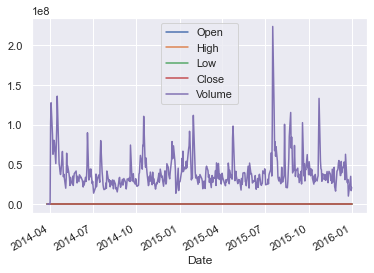

In [51]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
goog.plot()

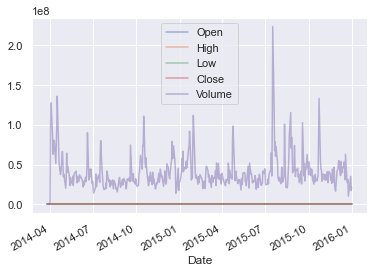

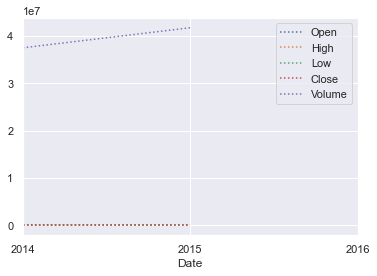

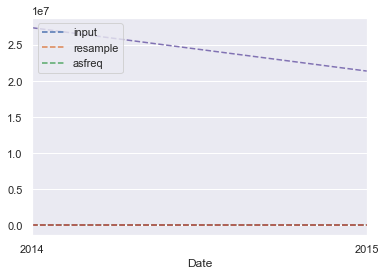

In [50]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left')

For up-sampling, resample() and asfreq() are largely equivalent, though resample has many more options available. In this case, the default for both methods is to leave the up-sampled points empty, that is, filled with NA values. Just as with the pd.fillna() function discussed previously, asfreq() accepts a method argument to specify how values are imputed. Here, we will resample the business day data at a daily frequency (i.e., including weekends):

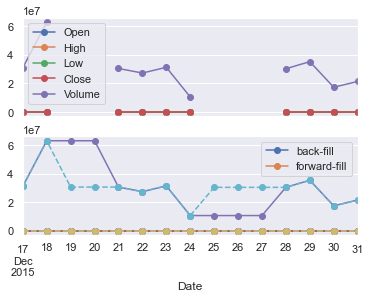

In [52]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

#### Time-shifts

Another common time series-specific operation is shifting of data in time. Pandas has two closely related methods for computing this: shift() and tshift() In short,\
`the difference between them is that shift() shifts the data, while tshift() shifts the index. In both cases, the shift is specified in multiples of the frequency.`

`Here we will both shift() and tshift() by 900 days;`

/var/folders/7f/4z7lvktj44g121hm_1s6v18h0000gn/T/ipykernel_83985/1419339079.py:8: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  goog.tshift(900).plot(ax=ax[2])


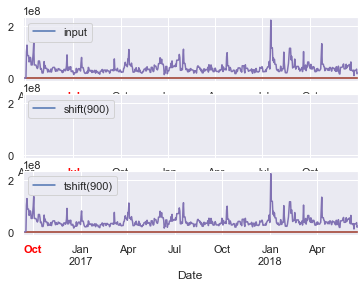

In [53]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

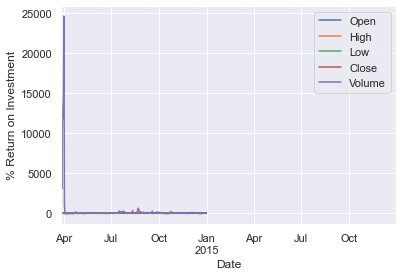

In [58]:
ROI = 100 * (goog.shift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

#### Rolling windows

Rolling statistics are a third type of time series-specific operation implemented by Pandas.\
`These can be accomplished via the rolling() attribute of Series and DataFrame objects, which returns a view similar to what we saw with the groupby operation (see Aggregation and Grouping). This rolling view makes available a number of aggregation operations by default.`

For example, here is the one-year centered rolling mean and standard deviation of the Google stock prices:

In [59]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

ValueError: If using all scalar values, you must pass an index